# 03.2 - hyperparameters influence on CatBoost 

In [1]:
import sys
from pathlib import Path

project_root = Path.cwd().parent
sys.path.append(str(project_root))

print("Project root added to sys.path:", project_root)

Project root added to sys.path: e:\.1\6 semestr\Podstawy sztucznej inteligencji\Projekt\football-prediction


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score, accuracy_score
from tqdm import tqdm
from pathlib import Path

from src.data_loader import load_data
from src.features import extract_features
from src.constants import FEATURE_COLUMNS
from src.model import _build_cat

## Data Preparation
As before

In [4]:
input_path = Path.cwd().parent / "data" / "processed" / "model_input.parquet"

df = extract_features(load_data(input_path)).dropna(subset=FEATURE_COLUMNS + ["result"])
X, y = df[FEATURE_COLUMNS], df["result"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [5]:
def evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)
    return {
        "f1_macro": f1_score(y_test, y_pred, average="macro"),
        "accuracy": accuracy_score(y_test, y_pred)
    }

## Experiment Function

In [6]:
def run_cat_experiment(param_name, param_values, base_config=None):
    if base_config is None:
        base_config = {}

    results = []

    for val in tqdm(param_values):
        cfg = base_config.copy()
        cfg[param_name] = val
        model = _build_cat(cfg)
        model.fit(X_train_res, y_train_res, verbose=False)
        scores = evaluate(model, X_test, y_test)
        scores[param_name] = val
        results.append(scores)

    return pd.DataFrame(results)

In [7]:
def plot_results(df, param_name):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    sns.lineplot(data=df, x=param_name, y="f1_macro", marker="o", ax=axes[0])
    axes[0].set_title(f"Macro F1 vs {param_name}")
    axes[0].grid(True)

    sns.lineplot(data=df, x=param_name, y="accuracy", marker="o", ax=axes[1])
    axes[1].set_title(f"Accuracy vs {param_name}")
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

## Experiment: Number of iterations parameter

100%|██████████| 5/5 [01:04<00:00, 12.99s/it]


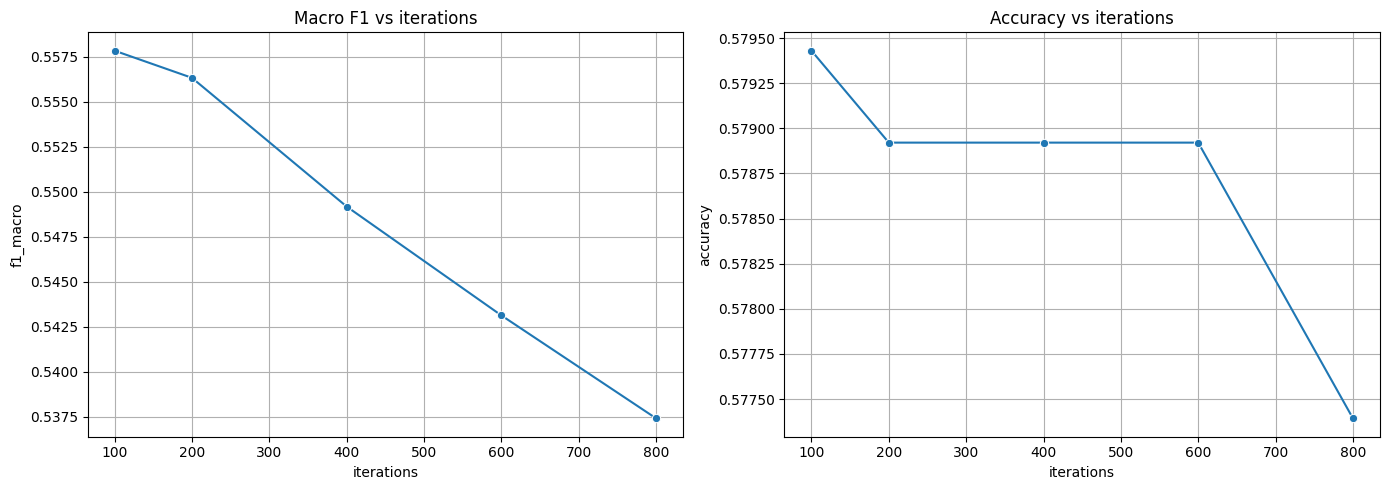

In [8]:
iters = [100, 200, 400, 600, 800]
df_iter = run_cat_experiment("iterations", iters)
plot_results(df_iter, "iterations")

## Experiment: max_depth

100%|██████████| 4/4 [01:52<00:00, 28.12s/it]


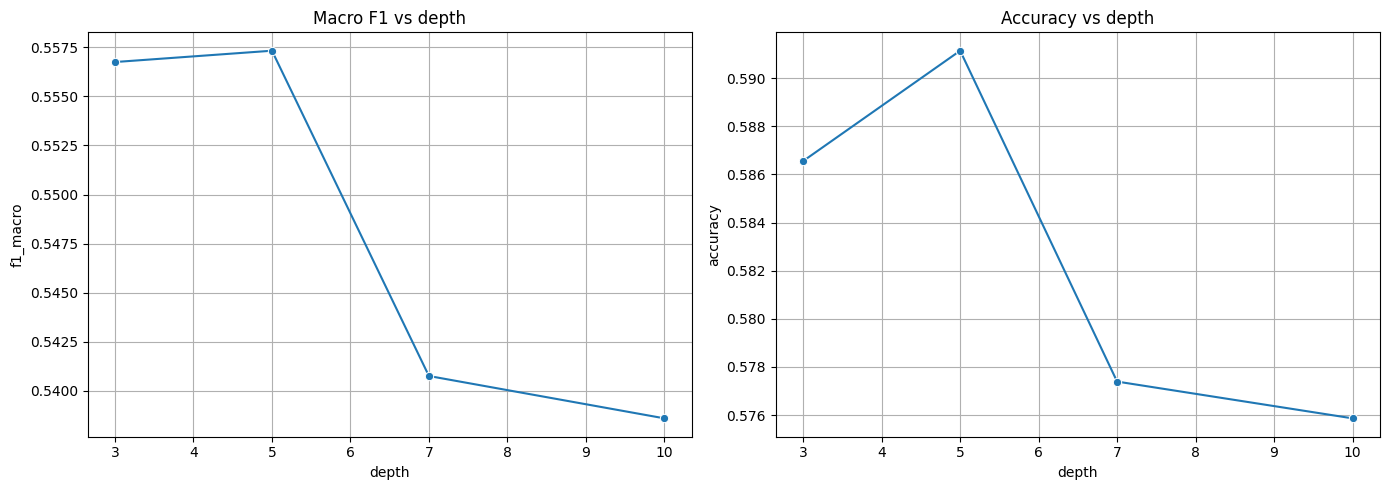

In [9]:
depths = [3, 5, 7, 10]
df_depth = run_cat_experiment("depth", depths)
plot_results(df_depth, "depth")

## Experiment: learning rate

100%|██████████| 5/5 [02:10<00:00, 26.16s/it]


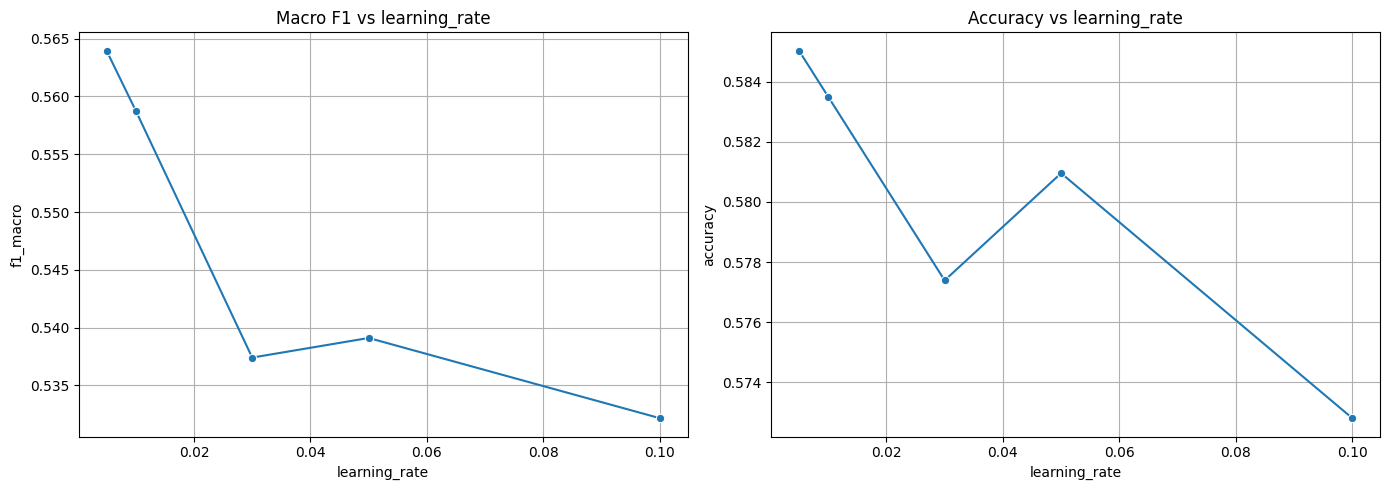

In [10]:
lr_vals = [0.005, 0.01, 0.03, 0.05, 0.1]
df_lr = run_cat_experiment("learning_rate", lr_vals)
plot_results(df_lr, "learning_rate")

## Experiment: regularization


100%|██████████| 5/5 [02:04<00:00, 24.82s/it]


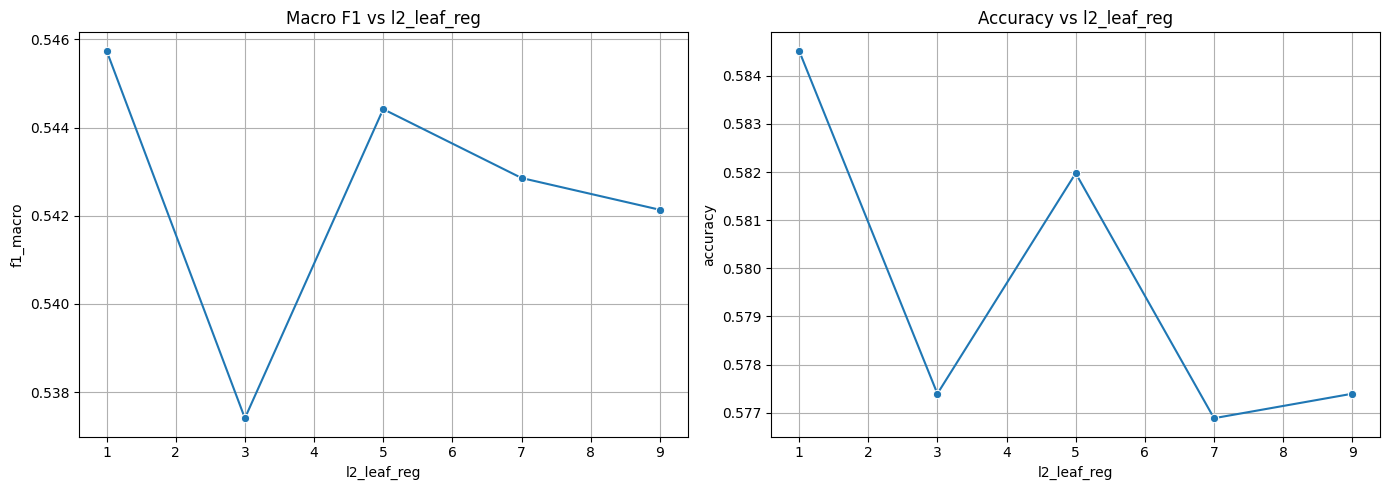

In [11]:
l2_vals = [1, 3, 5, 7, 9]
df_l2 = run_cat_experiment("l2_leaf_reg", l2_vals)
plot_results(df_l2, "l2_leaf_reg")